### Programming for A&A:

### Assignment 1: Maxwell A. Fine 14880725

This is the alternative Assignment using numpy!

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [16]:
# functions 

def read_header(data_file_csv):
    '''Reads in the header of the data_file_csv and returns a dictionary which maps the
    station name onto the station number. Uses the open python method.
    
    Also, Reads in the last-but-one line
    of the header with the list of variable names and returns a dictionary to map a variable name to its
    position in the list (starting with 0), i.e. to map a variable to the corresponding column index in the
    data.

    Args:
    data_file_csv: str
                   filename of the data file to read in, expects a .csv file

    Returns:
    stn_dict: dict
              A dict mapping station names to station numbers

    var_dict: dict
              A dict map a variable name to its position in the list (starting with 0)
    '''

    # read in data_file_csv's header
    header_lines = []
    with open(data_file_csv, 'r') as f:
        for line in f:
            if line[0] == '#':
                header_lines.append(line)
            else:
                break

    # stn dict
    # lets map station names to station numbers
    # starts after line with '# STN      LON(east)   LAT(north)     ALT(m)  NAME\n'
    # ends after blank line
    start_value = '# STN      LON(east)   LAT(north)     ALT(m)  NAME\n' 
    start_index = header_lines.index(start_value)
    end_index = 55 # figure out better method later 

    # read in stn names, and stn number data, split along spaces and make dict
    stn_data = header_lines[start_index +1 :end_index]
    stn_dict = {} # init dict
    for line in stn_data:
        stn_number = line[2:5] # assuming a 3 digit number only, will fix later
        split_line = line.split(maxsplit=5) 
        stn_name = split_line[-1][0:-1] # need to remove the \n
        stn_dict[stn_name] = stn_number

    # var_dict
    var_names = header_lines[-2][2:-1].strip().split(',') # makes a list of strings from the 2nd to last line in the header
    var_dict = {var_name.strip(): index for index, var_name in enumerate(var_names)} # fancy one liner
    print(var_dict)
    return stn_dict, var_dict

# new numpy method for reading in header

def np_read_header(data_file_csv,):
    '''Reads in the header of the data_file_csv and returns a dictionary which maps the
    station name onto the station number. Uses the open python method.
    
    Also, Reads in the last-but-one line
    of the header with the list of variable names and returns a dictionary to map a variable name to its
    position in the list (starting with 0), i.e. to map a variable to the corresponding column index in the
    data.

    Uses Numpy methods

    Args:
    data_file_csv: str
                   filename of the data file to read in, expects a .csv file

    Returns:
    stn_dict: dict
              A dict mapping station names to station numbers

    var_dict: dict
              A dict map a variable name to its position in the list (starting with 0)
    '''

    header_lines = np.genfromtxt(data_file_csv, delimiter='\n', skip_header=0, comments='mmm', dtype=str)
    # seperate header lines from data using the '#' starting character
    header_mask = np.char.startswith(header_lines, '#')
    header_lines = header_lines[header_mask]
    
    # stn dict
    # lets map station names to station numbers
    # starts after line with '# STN      LON(east)   LAT(north)     ALT(m)  NAME\n'
    # ends after blank line
    start_str = '# STN      LON(east)   LAT(north)     ALT(m)  NAME' 
    start_index = np.where(header_lines == start_str)

    # read in stn names, and stn number data, split along spaces and make dict
    stn_data = header_lines[start_index[0][0] +1:]
    stn_dict = {} # init dict
    for line in stn_data:
        # stop if line is blank
        is_blank_line = len(line) < 2
        if is_blank_line == True:
            break
        split_line = line.split(maxsplit=5)
        stn_number = split_line[1][:-1]
        stn_name = split_line[-1]
        stn_dict[stn_name] = stn_number
    

    # var_dict
    var_names = header_lines[-2][2:-1].strip().split(',') # makes a list of strings from the 2nd to last line in the header
    var_dict = {var_name.strip(): index for index, var_name in enumerate(var_names)} # fancy one liner
    return stn_dict, var_dict



def read_data(data_file_csv,):
    '''Reads in all the data (following the header) in data_file_csv, returning it as a
    numpy arr. Empty fields are set to np.nan. The first column (station number) into an integer. The second column
    (date) may be kept as a string and be converted or modified later. The remaining
    values should be converted into floats (they are continuous values, even if rounded
    to whole numbers

    Uses Numpy Methods

    Args:
    data_file_csv: str
                filename of the data file to read in, expects a .csv file

    var_dict: dict
            A dict map a variable name to its position in the list (starting with 0)).

    Returns:
    csv_data ndarry, dtype=float:
            A numpy array of station data, n by len(var_dict) with one index corresponding to var_dict's contents
            dtype of array is float!
    '''
    csv_data = np.genfromtxt(data_file_csv, delimiter=',', skip_header=0,)
    return csv_data


# data proccesing functions 

def get_monthly_avg(stn_number, csv_data, key, var_dict, set_zero_data=False):
    '''Calculates the monthly averags for a given stn_number for a given data key
    returns an array with 12 of the mean value for the corresponding month 1== January
    is nan protected for missing data.

    Uses numpy methods.
    
    Args:
    stn_number: float
                number of the weather station
    
    csv_data: ndarray
              weather station data for all stations
    
    key: str
         key from the var_dict we want the data for
    
    var_dict: dict
              dict containing the variable names and corresponding indexes in the csv_data
              
    Optional Args:
    set_zero_data: Boolian, default=False
                   If true, sets data with values less then 0 to be 0
    
    Returns:
    monthly_avg, monthly_std

    monthly_avg: ndarray
                 array of the monthly averages for 12 months

    monthly_std: ndarray
                 array of the monthly standard deviations for 12 months
    '''

    # get stn data, and make datetime objs array
    key_index = var_dict[key]
    stn_data  = csv_data[csv_data[:,0] == stn_number]

    float_dates = stn_data[:,1]
    # Convert the NumPy array of floats to datetime objects
    date_int = np.array(float_dates, dtype=int)  # Convert floats to strings
    date_strs = np.array(date_int, dtype=str)  # Convert floats to strings
    date_objs = np.array([datetime.strptime(date_str, '%Y%m%d') for date_str in date_strs])

    # stn_data is [n, 41] we want to sort by month
    months = np.array([date.month for date in date_objs])
    unique_months = np.unique(months)

    # init results arrays 
    monthly_avg = np.zeros(12)
    monthly_std = np.zeros(12)

    for month in unique_months:
            i = month
            mask = (months == month)
            if set_zero_data is True:
                # set all - values to 0
                stn_data[:, key_index][mask][stn_data[:, key_index][mask] < 0] = 0
            monthly_avg[i-1] = np.nanmean(stn_data[:,key_index][mask])
            monthly_std[i-1] = np.nanstd(stn_data[:,key_index][mask])
    return monthly_avg, monthly_std


# plotting functions

def plot_data(station_name, csv_data, var_dict, stn_dict, save=True, format='.pdf', dpi=300, close=True):
    '''Makes a snazzy looking plot for the given weather station! Plots min, max temp (in c!)
    Sunshine hours, and precipitation. Optionally saves, closes and some more features. If there
    a nan value it warns the user.
    
    Args:
    Station_name: str
                  name of the weather station to plot
                  
    csv_data: ndarray
              weather station data for all stations 
    
    var_dict: dict
              dict containing the variable names and corresponding indexes in the csv_data
              
    stn_dict: dict
              dict mapping station name to staion number
    
    Optional Args:
    save: Bool, defult = True
          If True, saves the plot in the dir this program is located/ executed
    
    format: str, default ='.pdf'
            format to save plot
    
    dpi: int
         dpi for plt
    
    close: Bool, default=True
           If true, closes plot after generating

    Returns:
    Hopefully None! but if it errors out, it returns the error message
    '''
    
    try:
        stn_number = float(stn_dict[station_name])
        time = np.arange(12)
        time = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        # Create a 2x2 grid of subplots
        # create a 1x3
        fig, axs = plt.subplots(3, 1, figsize=(12, 16))

        # Plot data in the first subplot
        # max temp
        key = 'TX'
        data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict)
        axs[0].scatter(time, data/10, color='k', linewidth=2, label='Max Temp')
        axs[0].errorbar(time, data/10, yerr=std_data/10, xerr=None, color='k', fmt='-.', linewidth=2)
        axs[0].set_ylabel('Temperature (°C)', size=15,)
        axs[0].set_title('Maximum & Minimum Temperature (°C)',size=15)
        axs[0].set_xlabel('Months', size=15)

        # min temp
        key = 'TN'
        data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict) 
        axs[0].scatter(time, data/10, color='blue', linewidth=2, label='Min Temp')
        axs[0].errorbar(time, data/10, yerr=std_data/10, xerr=None, color='blue', fmt='-.', linewidth=2)
        axs[0].legend(fontsize=12)
        axs[0].tick_params(axis='both', which='major', labelsize=15)

        # plot data in second subplot
        # sunshine
        key = 'SQ'
        data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict, set_zero_data=True)
        axs[1].scatter(time, data/10, color='gold',linewidth=2)
        axs[1].plot(time, data/10, color='gold', linewidth=2, linestyle='-.')
        axs[1].fill_between(time, data/10, color='gold', alpha=0.5)
        #axs[1].errorbar(time, data/10, yerr=std_data/10, xerr=None, color='gold', fmt='-.', linewidth=2)
        # error bars look ugly, take away from understanding
        axs[1].set_ylabel('Hours of Sunshine', size=15,)
        axs[1].set_title('Hours of Sunshine',size=15)
        axs[1].set_xlabel('Months', size=15)
        axs[1].tick_params(axis='both', which='major', labelsize=15)
        axs[1].set_ylim(0,1.1*np.max(data/10))

        # plot data in third subplot
        # preciptation
        key = 'RH'
        data, std_data = get_monthly_avg(stn_number, csv_data, key, var_dict, set_zero_data=True)
        axs[2].scatter(time, data, color='Green', linewidth=2)
        axs[2].plot(time, data, color='Green', linewidth=2, linestyle='-.')
        # axs[2].errorbar(time, data, yerr=std_data, xerr=None, color='Green',fmt='-.', linewidth=2)
        # error bars look ugly, take away from understanding
        axs[2].set_ylabel('Precipitation (mm/hour)', size=15,)
        axs[2].set_title('Precipitation',size=15)
        axs[2].set_xlabel('Months', size=15)
        axs[2].tick_params(axis='both', which='major', labelsize=15)
        axs[2].set_ylim(0,None)


        # Adjust spacing between subplots, other overall stuff
        plt.suptitle('Weather Station: ' + station_name +' Station Number: ' + str(int(stn_number) ), size=15)
        plt.subplots_adjust(top=0.3)  # Increase the top margin between subplots and supertitle
        plt.tight_layout()
        if save is True:
            plt.savefig(station_name + '_' + str(int(stn_number)) + format, dpi=dpi, bbox_inches='tight')

        if close is True:
            plt.close() # save ram if constantly making plots

    # if something goes wrong
    except Exception as e:
        plt.close()
        print('Failed to produce plots for weather station ' + station_name, e)
        return e
    

In [14]:
# cell to load in data and make dicts

data_file_csv ='KNMI_20200825.txt'
stn_dict, var_dict = np_read_header(data_file_csv,) # this is just numpy gen from text
csv_data = read_data(data_file_csv)


/tmp/ipykernel_29496/2470086599.py:199: RuntimeWarning: Mean of empty slice
  monthly_avg[i-1] = np.nanmean(stn_data[:,key_index][mask])
/home/afinemax/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/afinemax/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/tmp/ipykernel_29496/2470086599.py:199: RuntimeWarning: Mean of empty slice
  monthly_avg[i-1] = np.nanmean(stn_data[:,key_index][mask])
/home/afinemax/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/afinemax/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys

Failed to produce plots for weather station IJMOND Axis limits cannot be NaN or Inf


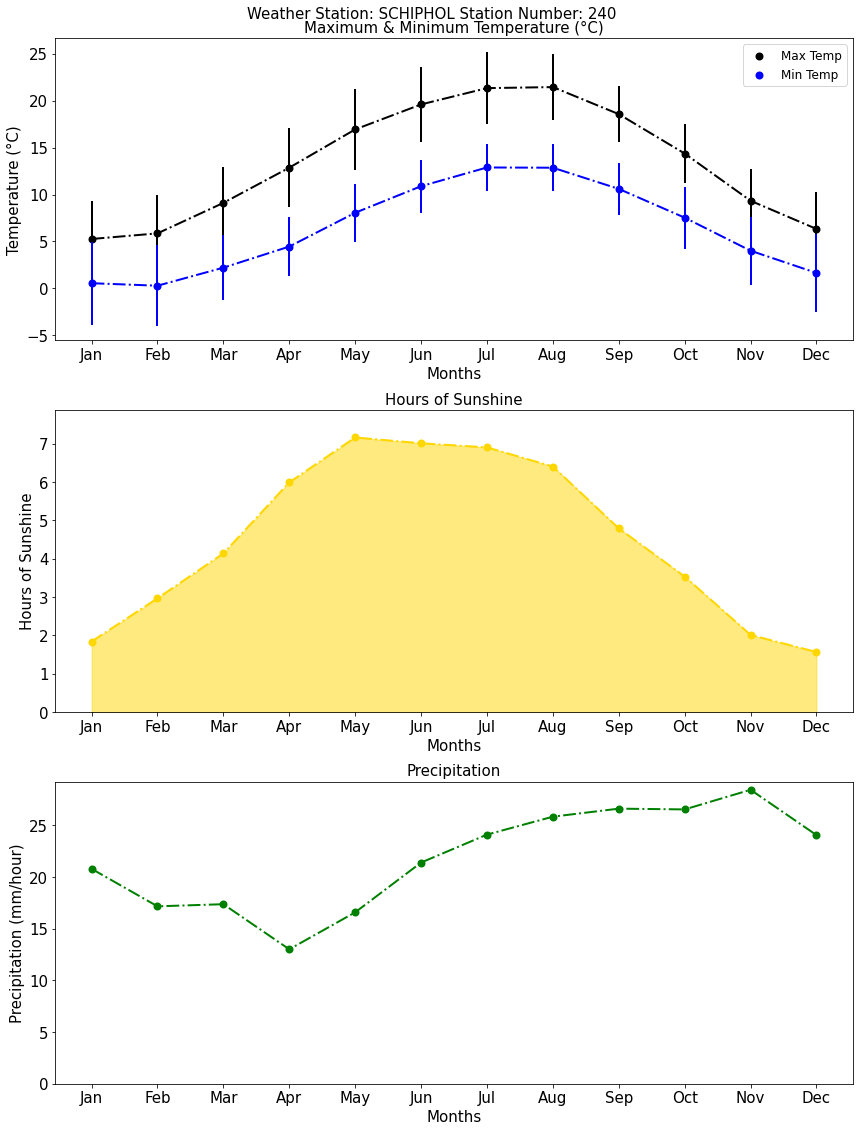

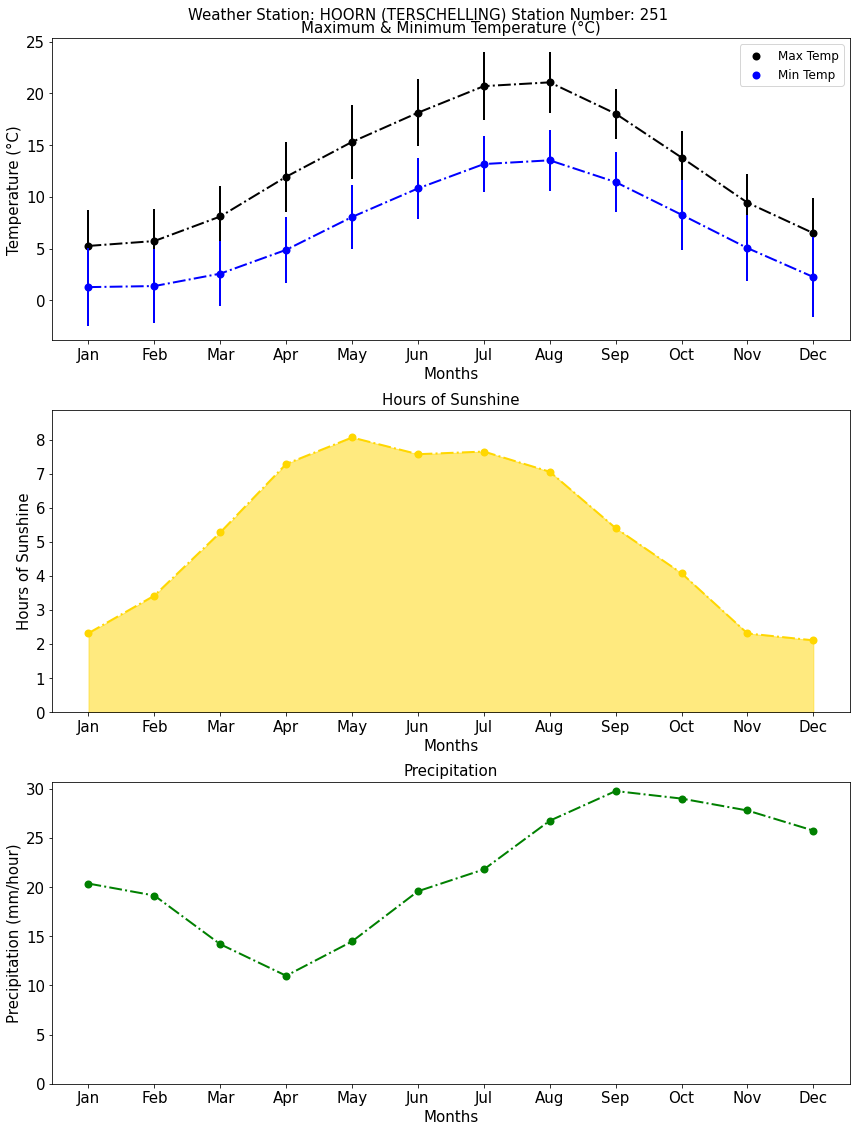

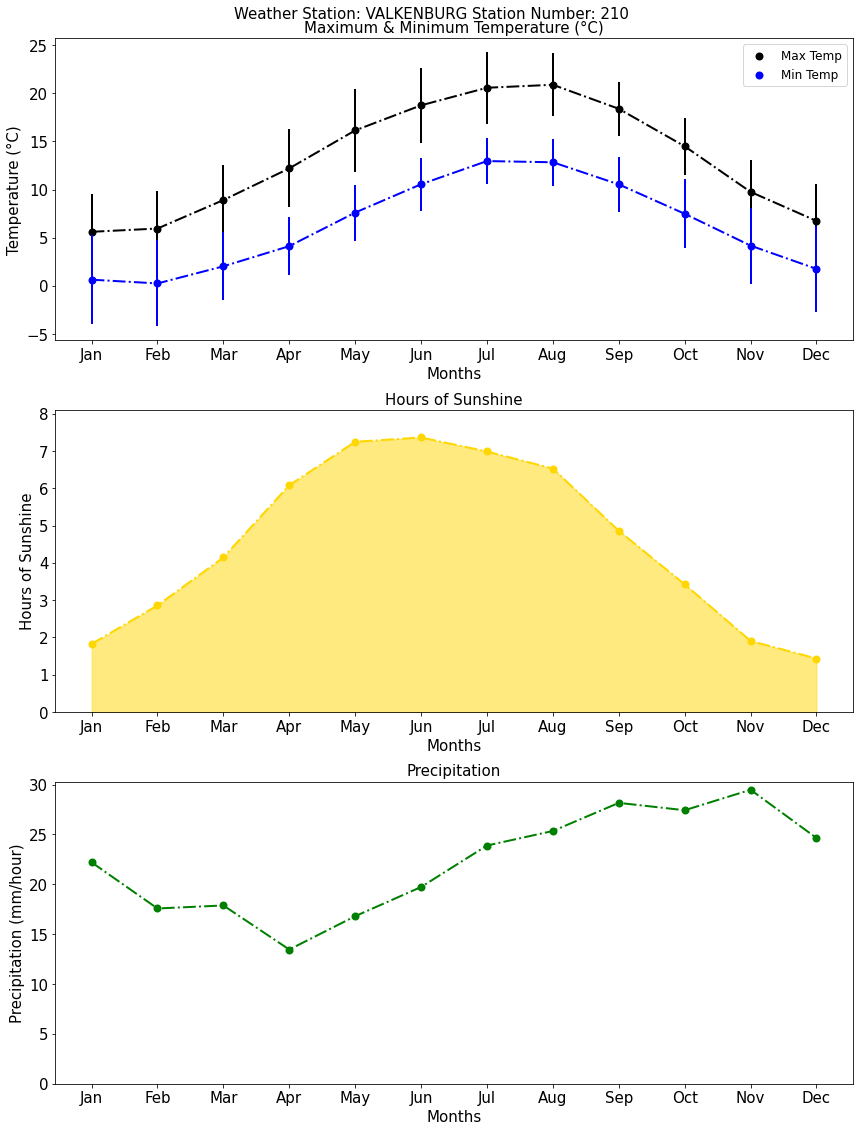

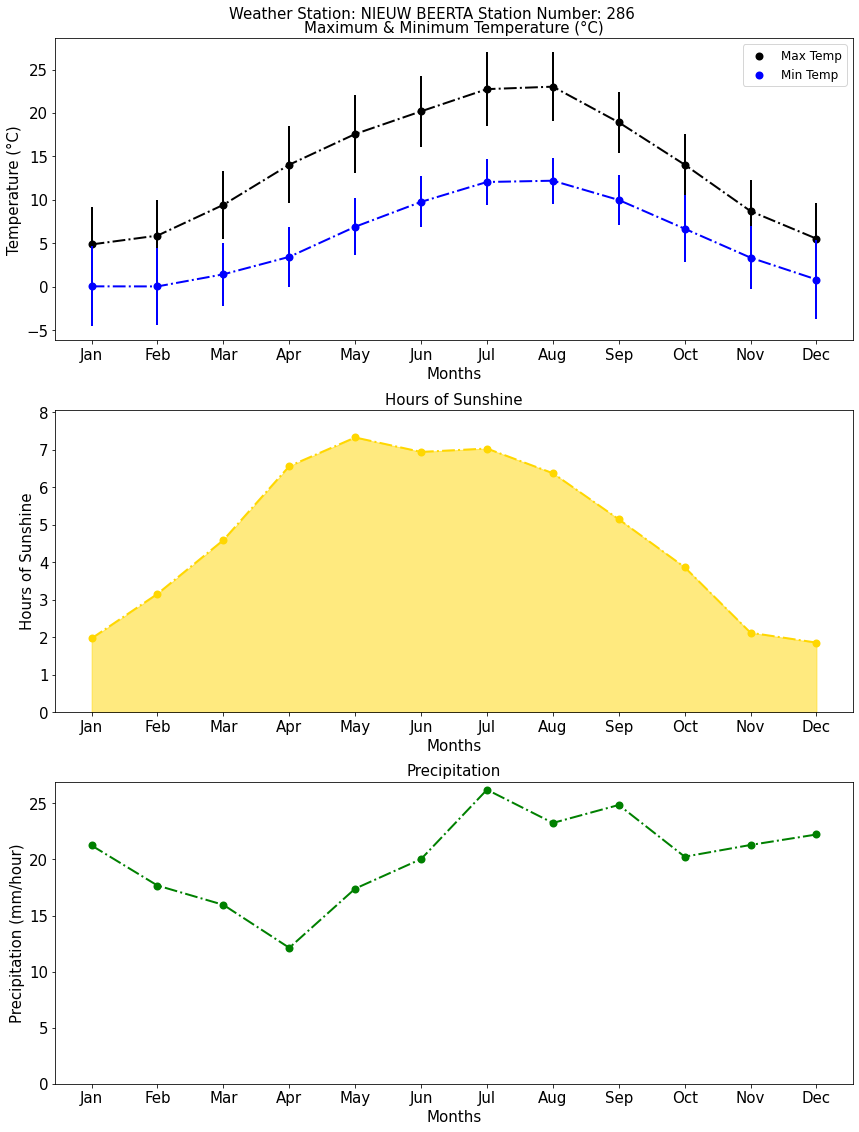

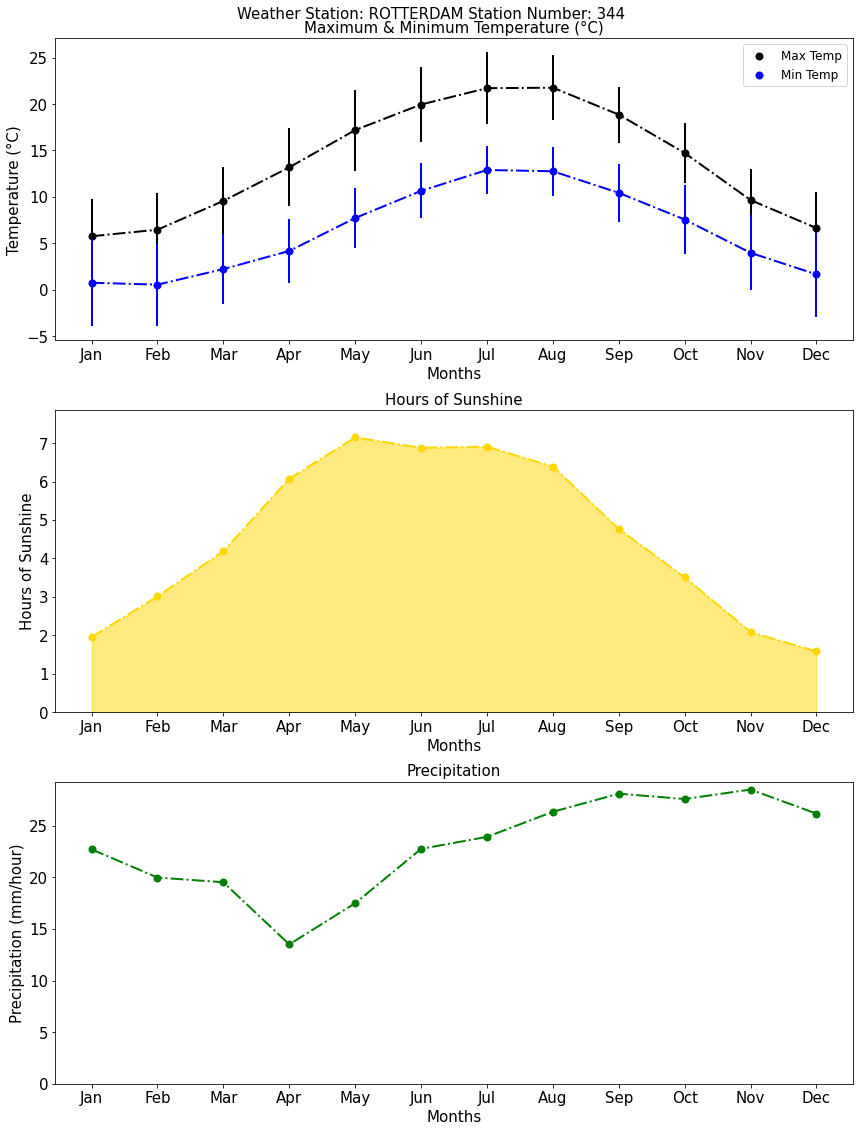

In [17]:
# cell to produce plots, lets make one for a few different stations 
# the first station 'IJMOND' is expected to fail, but the other stations should work
# (IJMOND doesn't have all the data needed to make the plots!)

station_names = ['IJMOND','SCHIPHOL','HOORN (TERSCHELLING)', 'VALKENBURG', 'NIEUW BEERTA', 'ROTTERDAM']

for station_name in station_names:
    plot_data(station_name, csv_data, var_dict, stn_dict, close=False)